In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

archivo_excel = "/content/Datos_Restaurante_Ejemplo_6meses.xlsx"
xls = pd.ExcelFile(archivo_excel)

# Cargar hojas necesarias
ventas = xls.parse("Ventas")
detalles_venta = xls.parse("DetallesVenta")
platillos = xls.parse("Platillos")
promociones = xls.parse("Promociones")
compras_ingredientes = xls.parse("ComprasIngredientes")
recetas = xls.parse("Recetas")
ingredientes = xls.parse("Ingredientes")

# Convertir fechas
ventas["fecha"] = pd.to_datetime(ventas["fecha"])
compras_ingredientes["fecha"] = pd.to_datetime(compras_ingredientes["fecha"])
ventas["mes"] = ventas["fecha"].dt.to_period("M")
compras_ingredientes["mes"] = compras_ingredientes["fecha"].dt.to_period("M")


In [3]:

eficacia_promos = ventas.copy()
eficacia_promos["tipo_promocion"] = eficacia_promos["id_promocion"].apply(lambda x: "Con Promoción" if pd.notnull(x) else "Sin Promoción")
eficacia_summary = eficacia_promos.groupby("tipo_promocion")["total"].agg(["count", "sum"]).reset_index()
eficacia_summary


,tipo_promocion,count,sum
0,Con Promoción,123,5896.45
1,Sin Promoción,395,23258.00


In [4]:

ordenes_mensuales = eficacia_promos.groupby(["mes", "tipo_promocion"])["id_venta"].count().reset_index(name="ordenes")
ordenes_mensuales


,mes,tipo_promocion,ordenes
0,2025-01,Con Promoción,10
1,2025-01,Sin Promoción,85
2,2025-02,Con Promoción,19
3,2025-02,Sin Promoción,66
4,2025-03,Con Promoción,11
5,2025-03,Sin Promoción,69
6,2025-04,Con Promoción,18
7,2025-04,Sin Promoción,82
8,2025-05,Con Promoción,53
9,2025-05,Sin Promoción,55


In [5]:

ventas_detalles = pd.merge(detalles_venta, ventas[["id_venta", "fecha"]], on="id_venta", how="left")
ventas_detalles["mes"] = ventas_detalles["fecha"].dt.to_period("M")
platillos_mensuales = ventas_detalles.groupby(["mes", "id_platillo"])["cantidad"].sum().reset_index()
platillos_mensuales = pd.merge(platillos_mensuales, platillos[["id_platillo", "nombre_platillo"]], on="id_platillo", how="left")
platillos_top = platillos_mensuales.sort_values(["mes", "cantidad"], ascending=[True, False]).groupby("mes").head(1)
platillos_top


,mes,id_platillo,cantidad,nombre_platillo
9,2025-01,10,51,Brownie con nuez
18,2025-02,9,62,Burrito de carne
23,2025-03,4,51,Tacos al pastor
34,2025-04,5,65,Hamburguesa clásica
43,2025-05,4,57,Tacos al pastor
50,2025-06,1,41,Pasta Alfredo con pollo


In [6]:

ventas_total_mes = ventas.groupby("mes")["total"].sum()
ventas_con_promo_mes = ventas[ventas["id_promocion"].notna()].groupby("mes")["total"].sum()
porcentaje_con_promo = (ventas_con_promo_mes / ventas_total_mes).reset_index(name="porcentaje_con_promocion")
porcentaje_con_promo


,mes,porcentaje_con_promocion
0,2025-01,0.064774
1,2025-02,0.212417
2,2025-03,0.106052
3,2025-04,0.140895
4,2025-05,0.447413
5,2025-06,0.221631


In [7]:

detalle_receta = pd.merge(detalles_venta, recetas, on="id_platillo", how="left")
detalle_receta["consumo"] = detalle_receta["cantidad"] * detalle_receta["cantidad_usada"]
detalle_receta = pd.merge(detalle_receta, ventas[["id_venta", "fecha"]], on="id_venta", how="left")
detalle_receta["mes"] = detalle_receta["fecha"].dt.to_period("M")

# Consumo mensual por ingrediente
consumo_ingredientes = detalle_receta.groupby(["mes", "id_ingrediente"])["consumo"].sum().reset_index()

# Compras mensuales por ingrediente
compras_mensuales = compras_ingredientes.groupby(["mes", "id_ingrediente"])["cantidad_comprada"].sum().reset_index()

compras_mensuales.head()


,mes,id_ingrediente,cantidad_comprada
0,2025-01,1,919.48
1,2025-01,2,235.15
2,2025-01,3,800.86
3,2025-01,4,1028.67
4,2025-01,5,380.85


In [8]:

tendencia_consumo = consumo_ingredientes.groupby("mes")["consumo"].sum().reset_index()
tendencia_consumo


,mes,consumo
0,2025-01,132808.51
1,2025-02,127097.54
2,2025-03,108438.92
3,2025-04,142055.56
4,2025-05,137380.30
5,2025-06,77170.63


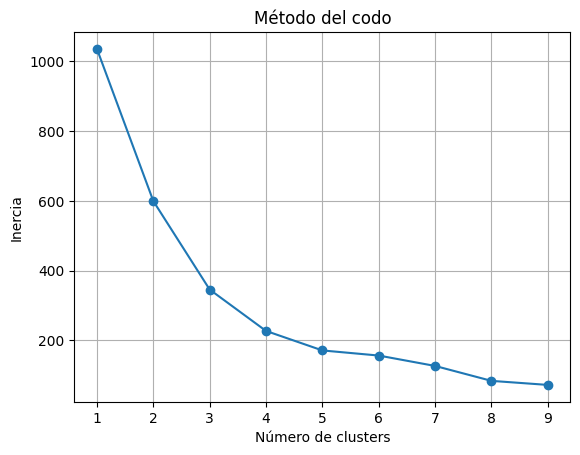

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar datos para clustering
cluster_data = ventas[["total", "tipo_pedido"]].dropna()
cluster_data["tipo_pedido_cod"] = cluster_data["tipo_pedido"].astype("category").cat.codes

# Escalar datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data[["total", "tipo_pedido_cod"]])

# Método del codo para determinar k
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.title("Método del codo")
plt.xlabel("Número de clusters")
plt.ylabel("Inercia")
plt.grid()
plt.show()

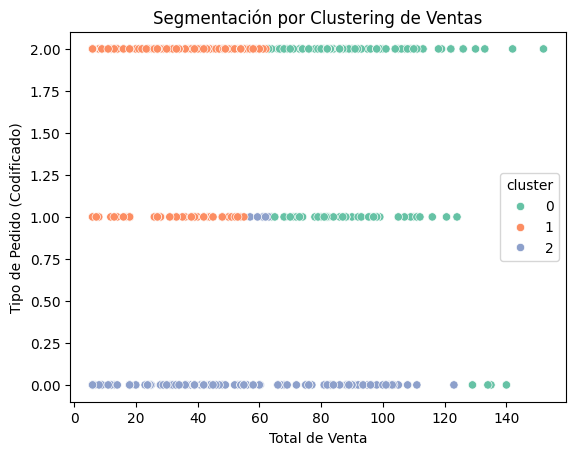

,count
cluster,
1,213
2,157
0,148


In [10]:
# Elegimos k=3 para segmentar
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data["cluster"] = kmeans.fit_predict(scaled_data)

# Visualizar clusters
sns.scatterplot(data=cluster_data, x="total", y="tipo_pedido_cod", hue="cluster", palette="Set2")
plt.title("Segmentación por Clustering de Ventas")
plt.xlabel("Total de Venta")
plt.ylabel("Tipo de Pedido (Codificado)")
plt.show()

cluster_data["cluster"].value_counts()
